### Identifying and categorsing the severity of diabetic retinopathy ####

This project is my attempt to develop a machine learning model which can identify the severity of diabetic reinopathy - a common retinal disease related to diabetes - from retina fundus images and forms part of my coursework for the **Imperial College Professional Certification in Machine Learning and Artifiicial Intelligence**

The source data for this projects comes from **RetinaMNIST** dataset which is part of the **MedMNIST** collection—a large-scale, MNIST-like benchmark for biomedical image classification. RetinaMNIST specifically contains retina fundus images, originally sourced from the DeepDRiD challenge, comprising about 1,600 retina fundus images. The main task with RetinaMNIST is ordinal regression, classifying the severity or progression stage of retinal diseases.

##### I will follow a standard ML project structure as follows:
1. Data Loading
2. Exploratory data analysis
3. Train / Test data split
4. Initial Neural network architecture
5. Model training
6. Model accuracy
7. Hyperparameter tuning via Bayesian Optimisation
8. Results
9. Interpretation and Conclusion


### 1. Data Loading


Images in RetinaMNIST are pre-processed and resized uniformly to 28x28 pixels for lightweight use in machine learning experiments. Class labels are standardized for ease of use without requiring specialist medical knowledge. MedMNIST has an extension called MedMNIST+, which includes higher-resolution versions of its datasets, including RetinaMNIST+. The RetinaMNIST+ images come in larger sizes such as 64x64, 128x128, and 224x224 pixels. This higher resolution makes the data more suitable for training more complex models and medical foundation models that require richer image details while still being a standardized benchmark. The size argument is used to select the relevant image size.

The RetinaMNIST dataset is already split into training / test and validation datasets. We will include a code option to generate our own train / test / validation splits as a demonstration of the capability. However for initial dataloading and data exploration we will use the training dataset

In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from collections import Counter
import medmnist
from medmnist import INFO, Evaluator

In [14]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


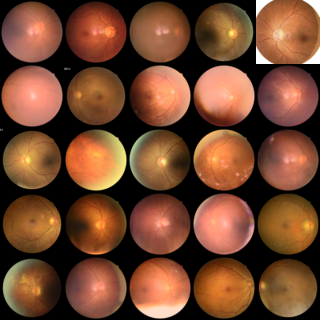

In [15]:
info = INFO['retinamnist']
DataClass = getattr(medmnist, info['python_class'])
image_size = 64

# preprocessing
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True, size=image_size)
test_dataset = DataClass(split='test', transform=data_transform, download=True, size=image_size)
validation_dataset = DataClass(split='val', transform=data_transform, download=True, size=image_size)
pil_dataset = DataClass(split='train', download=True, size=image_size) # to display images

# Let's have a look at the images
train_dataset.montage(length=5) 

<a id="data_analysis"></a>
### 2. Exploratory Data Analysis

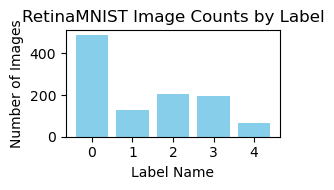

In [17]:
import matplotlib.pyplot as plt

labels = []
for label in train_dataset.labels:
    if hasattr(label, 'item'):
        labels.append(int(label.item()))
    elif isinstance(label, (np.ndarray, list, tuple)):
        labels.append(int(label[0]))
    else:
        labels.append(int(label))

# Count labels
label_counts = Counter(labels)

label_names = info.get('label', {})
label_count_pairs = []
for label_idx, count in label_counts.items():
    label_name = label_names.get(str(label_idx), str(label_idx))
    label_count_pairs.append((label_name, count))

# Sort by label name
label_count_pairs.sort(key=lambda x: x[0])

names = [name for name, count in label_count_pairs]
counts = [count for name, count in label_count_pairs]

# Create the bar chart
plt.figure(figsize=(3, 2))
bars = plt.bar(names, counts, color='skyblue')
plt.xlabel('Label Name')
plt.ylabel('Number of Images')
plt.title('RetinaMNIST Image Counts by Label')
plt.tight_layout()
plt.show()

The image lables are numerical and lack the context. The numerical labels in the RetinaMNIST dataset correspond to the severity levels of diabetic retinopathy. This dataset uses a 5-level ordinal grading system for diabetic retinopathy severity, reflecting disease progression stages.

| Numerical Label | Label Name        | Meaning (Diabetic Retinopathy Severity)                     |
|-----------------|-------------------|-------------------------------------------------------------|
| 0               | No DR             | No diabetic retinopathy detected                             |
| 1               | Mild              | Mild non-proliferative diabetic retinopathy                 |
| 2               | Moderate          | Moderate non-proliferative diabetic retinopathy             |
| 3               | Severe            | Severe non-proliferative diabetic retinopathy               |
| 4               | Proliferative DR  | Proliferative diabetic retinopathy (most advanced stage)    |

We will include these label names and meanings into our code


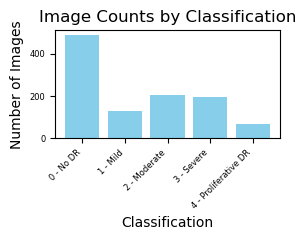

Image labels and counts:
0 - No DR: 486 images
1 - Mild: 128 images
2 - Moderate: 206 images
3 - Severe: 194 images
4 - Proliferative DR: 66 images

Image resolution (C x H x W): torch.Size([3, 64, 64])
Image resolution (HxW): 64 x 64
Number of training images: 1080
Number of test images: 400

Displaying sample images for each category:
Channel means for first image in 0 - No DR (R, G, B): [110.74194336  52.50024414  37.16918945]


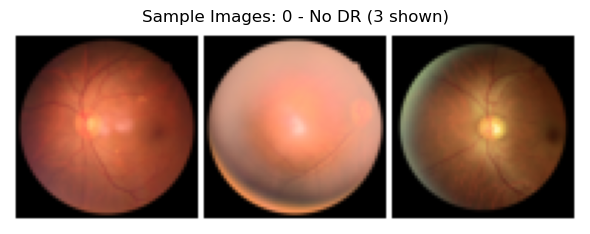

Channel means for first image in 1 - Mild (R, G, B): [31.90112305 20.53417969 12.4699707 ]


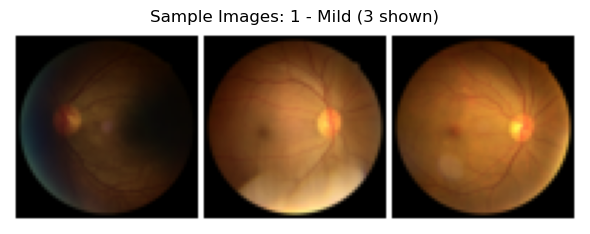

Channel means for first image in 2 - Moderate (R, G, B): [75.36499023 53.80566406 30.12011719]


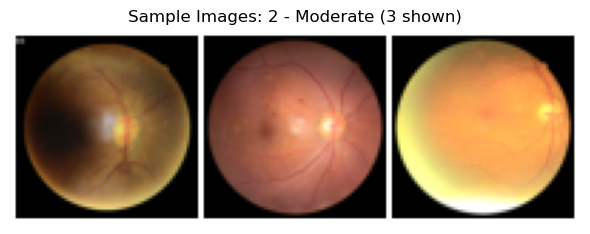

Channel means for first image in 3 - Severe (R, G, B): [97.35131836 48.05761719 25.98754883]


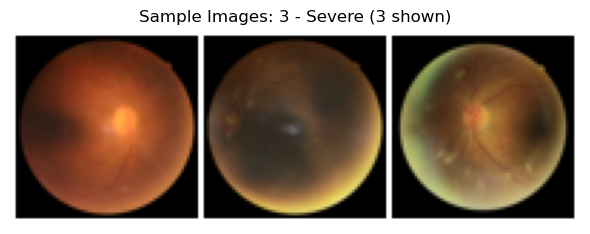

Channel means for first image in 4 - Proliferative DR (R, G, B): [74.7902832  49.32177734 20.57373047]


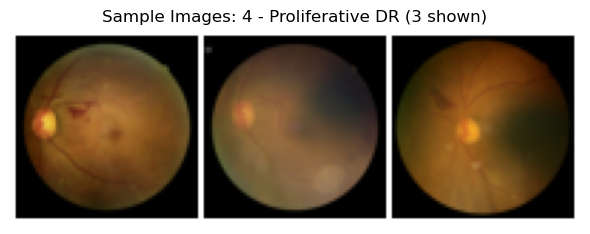

In [19]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from skimage.util import montage

retinamnist_labels = [
    {"Numerical Label": 0, "Label Name": "0 - No DR", "Meaning": "No diabetic retinopathy detected"},
    {"Numerical Label": 1, "Label Name": "1 - Mild", "Meaning": "Mild non-proliferative diabetic retinopathy"},
    {"Numerical Label": 2, "Label Name": "2 - Moderate", "Meaning": "Moderate non-proliferative diabetic retinopathy"},
    {"Numerical Label": 3, "Label Name": "3 - Severe", "Meaning": "Severe non-proliferative diabetic retinopathy"},
    {"Numerical Label": 4, "Label Name": "4 - Proliferative DR", "Meaning": "Proliferative diabetic retinopathy (most advanced stage)"},
]

num_to_name = {item['Numerical Label']: item['Label Name'] for item in retinamnist_labels}
labels = []
for label in train_dataset.labels:
    if hasattr(label, 'item'):
        labels.append(int(label.item()))
    elif isinstance(label, (np.ndarray, list, tuple)):
        labels.append(int(label[0]))
    else:
        labels.append(int(label))

label_counts_num = Counter(labels)
label_counts_named = {}
for num_label, count in label_counts_num.items():
    name = num_to_name.get(num_label, f"Unknown {num_label}")
    label_counts_named[name] = count

label_count_pairs = sorted(label_counts_named.items(), key=lambda x: x[0])

names = [name for name, count in label_count_pairs]
counts = [count for name, count in label_count_pairs]

plt.figure(figsize=(3, 2.5))
bars = plt.bar(names, counts, color='skyblue')
plt.xlabel('Classification')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=6)
plt.title('Image Counts by Classification')
plt.tight_layout()
plt.show()

print("Image labels and counts:")
for name, count in label_count_pairs:
    print(f"{name}: {count} images")

image_shape = train_dataset[0][0].shape
print(f"\nImage resolution (C x H x W): {image_shape}")
print(f"Image resolution (HxW): {image_shape[1]} x {image_shape[2]}")

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# Create montages for each category
print("\nDisplaying sample images for each category:")
for num_label in sorted(num_to_name.keys()):
    # Get indices of images with this label
    label_indices = [i for i, label in enumerate(labels) if label == num_label]
    
    # Select up to 6 random images (or fewer if not enough available)
    num_samples = min(3, len(label_indices))
    if num_samples == 0:
        continue
        
    selected_indices = np.random.choice(label_indices, size=num_samples, replace=False)
    
    # Get images
    sample_images = []
    for idx in selected_indices:
        img = train_dataset[idx][0]
        # Convert from CHW to HWC format
        if img.shape[0] in [1, 3]:  # Assuming 1 or 3 channels
            img = img.permute(1, 2, 0) if hasattr(img, 'permute') else np.transpose(img, (1, 2, 0))
        # Convert to numpy if it's a tensor
        if hasattr(img, 'numpy'):
            img = img.numpy()
        # Normalize from [-1, 1] to [0, 255] and convert to uint8
        if img.dtype != np.uint8:
            img = (img + 1) * 127.5  # Shift [-1, 1] to [0, 255]
            img = np.clip(img, 0, 255).astype(np.uint8)
        # Debug: Print mean values of each channel for the first image in each category
        if len(sample_images) == 0 and img.shape[-1] == 3:
            print(f"Channel means for first image in {num_to_name[num_label]} (R, G, B): {np.mean(img, axis=(0, 1))}")
        # Ensure RGB format: handle grayscale, assume 3-channel images are already RGB
        if img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1):
            img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB
        sample_images.append(img)
    
    # Stack images to create 4D array (n_images, height, width, channels)
    sample_images = np.stack(sample_images, axis=0)
    
    # Create montage
    montage_img = montage(sample_images, grid_shape=(1, 3), padding_width=2, fill=(255, 255, 255), channel_axis=-1)
    
    # Display montage
    plt.figure(figsize=(6, 4))
    plt.imshow(montage_img)
    plt.title(f"Sample Images: {num_to_name[num_label]} ({num_samples} shown)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

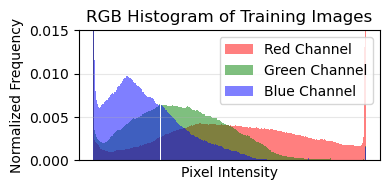

RGB Channel Statistics:
Red Channel - Mean: 100.50, Std: 81.80
Green Channel - Mean: 61.34, Std: 53.07
Blue Channel - Mean: 36.53, Std: 38.18


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Function to process images and compute RGB histograms
def compute_rgb_histogram(dataset):
    red_values = []
    green_values = []
    blue_values = []
    
    for idx in range(len(dataset)):
        img = dataset[idx][0]  # Get image tensor
        # Convert from CHW to HWC format
        if img.shape[0] in [1, 3]:  # Assuming 1 or 3 channels
            img = img.permute(1, 2, 0) if hasattr(img, 'permute') else np.transpose(img, (1, 2, 0))
        # Convert to numpy if it's a tensor
        if hasattr(img, 'numpy'):
            img = img.numpy()
        # Normalize from [-1, 1] to [0, 255] and convert to uint8
        if img.dtype != np.uint8:
            img = (img + 1) * 127.5  # Shift [-1, 1] to [0, 255]
            img = np.clip(img, 0, 255).astype(np.uint8)
        # Handle grayscale by repeating channels
        if img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1):
            img = np.repeat(img[..., np.newaxis], 3, axis=-1)
        # Assume RGB order (based on previous fix for blue tint)
        # Extract RGB channels
        red = img[..., 0].ravel()
        green = img[..., 1].ravel()
        blue = img[..., 2].ravel()
        red_values.extend(red)
        green_values.extend(green)
        blue_values.extend(blue)
    
    return np.array(red_values), np.array(green_values), np.array(blue_values)

# Compute histograms
red_vals, green_vals, blue_vals = compute_rgb_histogram(train_dataset)

# Create histogram plot
plt.figure(figsize=(4, 2))
plt.hist(red_vals, bins=256, color='red', alpha=0.5, label='Red Channel', density=True)
plt.hist(green_vals, bins=256, color='green', alpha=0.5, label='Green Channel', density=True)
plt.hist(blue_vals, bins=256, color='blue', alpha=0.5, label='Blue Channel', density=True)
plt.ylim(0, 0.015)
plt.xticks([])
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')
plt.title('RGB Histogram of Training Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print basic statistics
print("RGB Channel Statistics:")
print(f"Red Channel - Mean: {np.mean(red_vals):.2f}, Std: {np.std(red_vals):.2f}")
print(f"Green Channel - Mean: {np.mean(green_vals):.2f}, Std: {np.std(green_vals):.2f}")
print(f"Blue Channel - Mean: {np.mean(blue_vals):.2f}, Std: {np.std(blue_vals):.2f}")

### 3. Train / Test data split

The MedMNIST data in general, and the RetinaMNIST set in particular, are already split into training and test datasets. This is to allows comparison of model performance by various parties and ensure consistency across those building machine learning models on this data. I will keep the training / test data split as provided, although I may create some code to demonstrate the splitting of data into sets where we can specify the relative sizes of each set. Not for right now though - too much else to do...

### 4. Neural Network Architecture
Here we establish out base neural network architecture using pytorch

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define CNN architecture
class RetinaCNN(nn.Module):
    def __init__(self):
        super(RetinaCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv Layer 1: 3 input channels (RGB), 16 output channels
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x32x32
            # Conv Layer 2: 16 input channels, 32 output channels
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x16x16
            # Conv Layer 3: 32 input channels, 64 output channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: 64x8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 5)  # 5 classes
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Note: Dataset is already [-1, 1], so no additional normalization
])

### 5. Model training
Here we train our base model and get some baseline performance metrics

In [42]:
# Hyperparameters
batch_size = 32
num_epochs = 35
lr = 0.001

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = RetinaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Ensure labels are 1D integers
        if labels.dim() > 1:
            labels = labels.squeeze().long()
        elif not torch.is_tensor(labels) or labels.dtype != torch.long:
            labels = torch.tensor(labels, dtype=torch.long)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Ensure labels are 1D integers
            if labels.dim() > 1:
                labels = labels.squeeze().long()
            elif not torch.is_tensor(labels) or labels.dtype != torch.long:
                labels = torch.tensor(labels, dtype=torch.long)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Save model
torch.save(model.state_dict(), 'Base_retina_model_cnn.pth')

print('Training complete')


Epoch [1/35], Train Loss: 1.4086, Val Loss: 1.1584, Val Accuracy: 55.00%
Epoch [2/35], Train Loss: 1.2506, Val Loss: 1.1516, Val Accuracy: 53.33%
Epoch [3/35], Train Loss: 1.2007, Val Loss: 1.0844, Val Accuracy: 46.67%
Epoch [4/35], Train Loss: 1.1900, Val Loss: 1.1072, Val Accuracy: 52.50%
Epoch [5/35], Train Loss: 1.2227, Val Loss: 1.0329, Val Accuracy: 57.50%
Epoch [6/35], Train Loss: 1.1632, Val Loss: 1.0449, Val Accuracy: 51.67%
Epoch [7/35], Train Loss: 1.1932, Val Loss: 1.0429, Val Accuracy: 50.83%
Epoch [8/35], Train Loss: 1.2079, Val Loss: 1.0638, Val Accuracy: 58.33%
Epoch [9/35], Train Loss: 1.1647, Val Loss: 1.0862, Val Accuracy: 46.67%
Epoch [10/35], Train Loss: 1.1522, Val Loss: 1.1103, Val Accuracy: 47.50%
Epoch [11/35], Train Loss: 1.1352, Val Loss: 1.0666, Val Accuracy: 53.33%
Epoch [12/35], Train Loss: 1.1401, Val Loss: 1.0448, Val Accuracy: 48.33%
Epoch [13/35], Train Loss: 1.1492, Val Loss: 1.0776, Val Accuracy: 51.67%
Epoch [14/35], Train Loss: 1.1353, Val Loss: 1.

### 6. Model performance


Test Accuracy: 51.25%


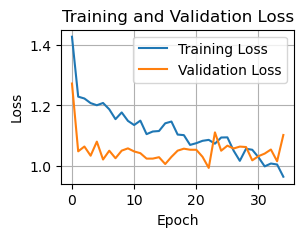

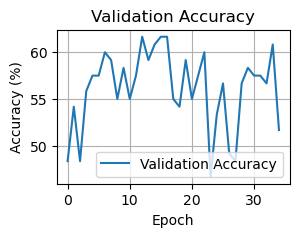

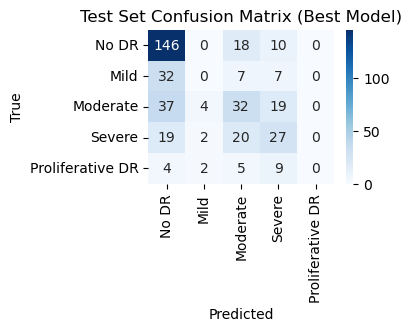

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        if isinstance(labels, np.ndarray):
            labels = torch.tensor(labels, dtype=torch.long).squeeze()
        elif labels.dim() > 1:
            labels = labels.squeeze().long()
        elif not torch.is_tensor(labels) or labels.dtype != torch.long:
            labels = torch.tensor(labels, dtype=torch.long)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')

# Plot training and validation loss
plt.figure(figsize=(3, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(3, 2))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print and plot test confusion matrix
cm_test = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(3, 2))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix (Best Model)')
plt.show()

Validation accuracy is not improving over epochs and is not very stable. So I will now look at evolving our model and optimising hyperparameters with a view to improving model accuracy.

### 7. Hyperparameter Optimisation using Bayesian Optimisation

#### Hyperparameters to Optimize
Here are the 5 hyperparameters I will look to optimise using Bayesian Optimisation. I will leverage the Optuna library for this and use the default acquisiton function (**Tree-structured Parzen Estimator**)
##### Learning Rate:
Continuous valued in the range **[1e-4, 1e-2]** – Covers small to moderate learning rates suitable for Adam. Continuous sampling allows fine-grained exploration around the current learning rate of 0.001.
##### Batch Size:
We will consider discrete batch sizes of **[16, 32, 64]**
##### Dropout Rate:
Continuous valuedin the range **[0.3, 0.7]** which will give us exploration of regularization strength between light and heavy dropout.
##### Number of Filters:
Discrete values of **[[8, 16, 32, 64], [16, 32, 64, 128], [32, 64, 128, 256]]** which helps keep the architecture manageable while testing model capacity.
##### Weight Decay:
Continuous valued in the range **[0.0, 1e-3]** to give us fine-tuning of regularization strength.

Trial 0: lr=0.000012, batch_size=32, dropout_rate=0.49, num_filters=[32, 64, 128], weight_decay=0.000759
Trial 0 Validation Accuracy: 50.83%
Trial 1: lr=0.000236, batch_size=16, dropout_rate=0.39, num_filters=[32, 64, 128], weight_decay=0.000038
Trial 1 Validation Accuracy: 51.67%
Trial 2: lr=0.000048, batch_size=32, dropout_rate=0.69, num_filters=[32, 64, 128], weight_decay=0.000631
Trial 2 Validation Accuracy: 50.00%
Trial 3: lr=0.000011, batch_size=32, dropout_rate=0.68, num_filters=[32, 64, 128], weight_decay=0.000527
Trial 3 Validation Accuracy: 54.17%
Trial 4: lr=0.000057, batch_size=32, dropout_rate=0.50, num_filters=[8, 16, 32], weight_decay=0.000202
Trial 4 Validation Accuracy: 49.17%
Trial 5: lr=0.000027, batch_size=32, dropout_rate=0.67, num_filters=[8, 16, 32], weight_decay=0.000478
Trial 5 Validation Accuracy: 49.17%
Trial 6: lr=0.000057, batch_size=16, dropout_rate=0.32, num_filters=[8, 16, 32], weight_decay=0.000829
Trial 6 Validation Accuracy: 49.17%
Trial 7: lr=0.00003

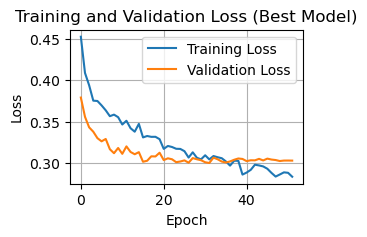

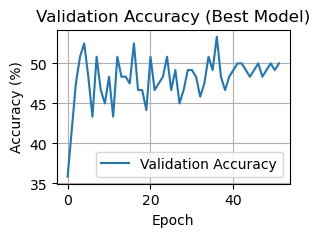

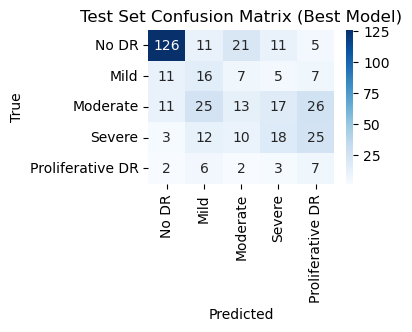

In [68]:
# Note: Ensure Optuna is installed: `conda install -c conda-forge optuna` or `pip install optuna`

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import optuna
from optuna.samplers import TPESampler

# Hyper-hyper-parameters
number_of_trials = 50  # Updated to 30 trials
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha if alpha is not None else torch.ones(5).to(device)
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# Define simplified CNN architecture
class RetinaCNN_BO(nn.Module):
    def __init__(self, num_filters, dropout_rate):
        super(RetinaCNN_BO, self).__init__()
        f1, f2, f3 = num_filters
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, f1, kernel_size=3, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(f1, f2, kernel_size=3, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(f2, f3, kernel_size=3, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(f3 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 5)  # 5 classes
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Compute class weights for imbalanced dataset
labels = []
for _, label in train_dataset:
    if isinstance(label, np.ndarray):
        label = label.item() if label.ndim > 0 else int(label)
    elif torch.is_tensor(label):
        label = label.item() if label.dim() > 0 else int(label)
    else:
        label = int(label)
    labels.append(label)
label_counts = Counter(labels)
n_classes = 5
class_weights = torch.tensor([1.0 / label_counts[i] for i in range(n_classes)], dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum() * n_classes  # Normalize weights

# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

# Hyperparameters
num_epochs = 100
patience = 20

# Data loaders
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    lr = trial.suggest_float('lr', 1e-5, 3e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    num_filters_idx = trial.suggest_categorical('num_filters_idx', [0, 1, 2])
    num_filters_list = [[8, 16, 32], [16, 32, 64], [32, 64, 128]]
    num_filters = num_filters_list[num_filters_idx]
    weight_decay = trial.suggest_float('weight_decay', 0.0, 1e-3)
    
    print(f'Trial {trial.number}: lr={lr:.6f}, batch_size={batch_size}, '
          f'dropout_rate={dropout_rate:.2f}, num_filters={num_filters}, weight_decay={weight_decay:.6f}')
    
    # Create data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss, optimizer, scheduler
    model = RetinaCNN_BO(num_filters=num_filters, dropout_rate=dropout_rate).to(device)
    criterion = FocalLoss(gamma=4.0, alpha=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop with early stopping
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_epoch_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            if isinstance(labels, np.ndarray):
                labels = torch.tensor(labels, dtype=torch.long).squeeze()
            elif labels.dim() > 1:
                labels = labels.squeeze().long()
            elif not torch.is_tensor(labels) or labels.dtype != torch.long:
                labels = torch.tensor(labels, dtype=torch.long)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                if isinstance(labels, np.ndarray):
                    labels = torch.tensor(labels, dtype=torch.long).squeeze()
                elif labels.dim() > 1:
                    labels = labels.squeeze().long()
                elif not torch.is_tensor(labels) or labels.dtype != torch.long:
                    labels = torch.tensor(labels, dtype=torch.long)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Scheduler step
        scheduler.step(epoch_val_loss)
        
        # Early stopping
        if epoch_val_loss < best_epoch_val_loss:
            best_epoch_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    print(f'Trial {trial.number} Validation Accuracy: {val_accuracy:.2f}%')
    return val_accuracy

# Run Bayesian optimization
study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=number_of_initial_trials))
study.optimize(objective, n_trials=number_of_trials)

# Get best trial
best_trial = study.best_trial
print(f'\nBest Hyperparameters: {best_trial.params}')
print(f'Best Validation Accuracy: {best_trial.value:.2f}%')

# Train and evaluate best model
best_params = best_trial.params
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
model = RetinaCNN_BO(num_filters=[[8, 16, 32], [16, 32, 64], [32, 64, 128]][best_params['num_filters_idx']],
                     dropout_rate=best_params['dropout_rate']).to(device)
criterion = FocalLoss(gamma=4.0, alpha=class_weights)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Train with best parameters
train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        if isinstance(labels, np.ndarray):
            labels = torch.tensor(labels, dtype=torch.long).squeeze()
        elif labels.dim() > 1:
            labels = labels.squeeze().long()
        elif not torch.is_tensor(labels) or labels.dtype != torch.long:
            labels = torch.tensor(labels, dtype=torch.long)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            if isinstance(labels, np.ndarray):
                labels = torch.tensor(labels, dtype=torch.long).squeeze()
            elif labels.dim() > 1:
                labels = labels.squeeze().long()
            elif not torch.is_tensor(labels) or labels.dtype != torch.long:
                labels = torch.tensor(labels, dtype=torch.long)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step(epoch_val_loss)
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_retina_cnn.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

print(f'Final Validation Accuracy: {val_accuracy:.2f}%')

# Load best model
model.load_state_dict(torch.load('best_retina_cnn.pth'))

# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        if isinstance(labels, np.ndarray):
            labels = torch.tensor(labels, dtype=torch.long).squeeze()
        elif labels.dim() > 1:
            labels = labels.squeeze().long()
        elif not torch.is_tensor(labels) or labels.dtype != torch.long:
            labels = torch.tensor(labels, dtype=torch.long)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy with Best Model: {test_accuracy:.2f}%')

# Print confusion matrix
cm_test = confusion_matrix(test_labels, test_preds)
print("Test Confusion Matrix:\n", cm_test)

# Plot training and validation loss
plt.figure(figsize=(3, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(3, 2))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix (Best Model)')
plt.show()

### 8. Results

**Results**
Best Hyperparameters: {'lr': 1.2340788194638802e-05, 'batch_size': 16, 'dropout_rate': 0.5894002548002665, 'num_filters_idx': 1, 'weight_decay': 0.000565329342145327}
Best Validation Accuracy: 56.67%
Test Accuracy with Best Model: 45.00%
Test Confusion Matrix:
 [[126  11  21  11   5]
 [ 11  16   7   5   7]
 [ 11  25  13  17  26]
 [  3  12  10  18  25]
 [  2   6   2   3   7]]


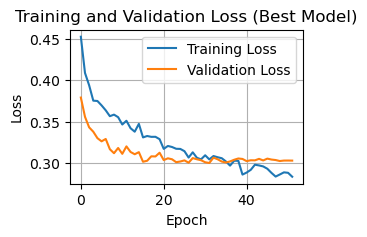

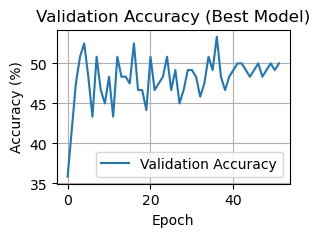

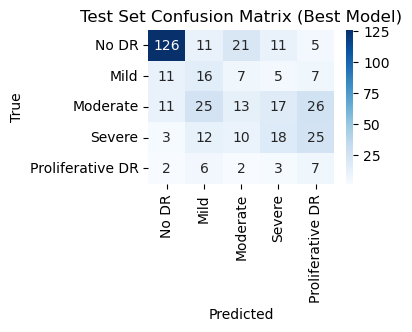

In [77]:
print(f'**Results**\nBest Hyperparameters: {best_trial.params}')
print(f'Best Validation Accuracy: {best_trial.value:.2f}%')

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy with Best Model: {test_accuracy:.2f}%')

# Print confusion matrix
cm_test = confusion_matrix(test_labels, test_preds)
print("Test Confusion Matrix:\n", cm_test)

# Plot training and validation loss
plt.figure(figsize=(3, 2))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(3, 2))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (Best Model)')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix (Best Model)')
plt.show()

### 9. Interpretation and Conclusion ###

The model results are disappointing in term so the **Test set accuracy of 45%**. The accuracy should really be in excess of 60% and so we are falling short of that figure.
The model performs well when there is No DR (accuracy ~72.4%) but struggles with minority classes (Mild: ~34.8%, Moderate: ~14.1%, Severe: ~26.5%, Proliferative DR: ~35.0%). This is quite likely due to the imbalance in the respective class sizes, and the relatively small dataset size (1,600 training images).
That said, time constraints around completing the project mean that I have not invested much time in optimisaing or improving the model or code. The final test accuracy and confusion matrix are shown above. There are plenty of things to consider looking at to improve the model given more time:
* Further hyperparamter optimisation
* Loking at alternative base convolutional neural network architectures (e.g. adding in normalisation or drop out or reducing the fully connected layer
* Introducing weighted smapling
* Increasing training stability byincreasing the number of epochs or increasing patience

This model is intended solely for educational purposes, such as benchmarking CNNs or prototyping medical image analysis on the RetinaMNIST dataset. It should not be used for clinical diagnosis or real-time patient care due to its moderate test accuracy (45.00%) and poor performance on minority classes (e.g., Moderate: ~14.1%, Severe: ~26.5%), which could lead to misdiagnosis. The model’s low resolution (64x64) and U.S.-centric data limit its generalizability. For research, use saved models (trial_{n}_retina_cnn.pth, best_retina_cnn_run_{n}.pth) to explore improvements, ensuring compliance with MedMNIST’s CC BY 4.0 license.